In [8]:
import PIL
import os
import pyautogui
import time
import win32gui
import win32con
from typing import Optional, Union
from loguru import logger
from ahk import AHK
from datetime import datetime
from enums import HyperCoreHealth
import configparser
import os
import colorama


logger.add("logs/log_{time}.log")
ahk = AHK()

COLOR_SIMILARITY_THRESHOLD = 15

def load_configs():
    """
    Load all the configurations from the config.ini file
    """

    global PLAYER_BASE_DAMAGE, PLAYER_CRITICAL_CHANCE, PLAER_CRITICAL_MULTIPLIER, TICKETS_MAX_AMOUNT, MINIGAME_PET_POSITION_ROW, MINIGAME_PET_POSITION_COLUMN, SHOULD_PLAY_MINIGAME, OUTPUT_FOLDER
    config = configparser.ConfigParser()
    config.read("config.ini")
    PLAYER_BASE_DAMAGE = config.getint("PLAYER_STATS", "BASE_DEMAGE")
    PLAYER_CRITICAL_CHANCE = config.getfloat("PLAYER_STATS", "CRITICAL_CHANCE")
    PLAER_CRITICAL_MULTIPLIER = config.getfloat("PLAYER_STATS", "CRITICAL_MULTIPLIER")
    TICKETS_MAX_AMOUNT = config.getint("PLAYER_STATS", "TICKETS_MAX_AMOUNT")
    MINIGAME_PET_POSITION_ROW = config.getint("PLAYER_STATS", "MINIGAME_PET_POSITION_ROW")
    MINIGAME_PET_POSITION_COLUMN = config.getint(
        "PLAYER_STATS", "MINIGAME_PET_POSITION_COLUMN"
    )

    SHOULD_PLAY_MINIGAME = config.getboolean("OTHER", "SHOULD_PLAY_MINIGAME")
    OUTPUT_FOLDER = config.get("OTHER", "OUTPUT_FOLDER")
    SHOULD_PLAY_MINIGAME = config.getboolean("OTHER", "SHOULD_PLAY_MINIGAME")

        
    if not os.path.exists(OUTPUT_FOLDER):
        ahk.msg_box(
            title="Error!",
            text="Can't locate your output folder. Please, select another one",
        )
        folder = ahk.folder_select_box(new_dialog_style=True)
        if folder is None:
            raise SystemExit
        
        # now, update our config
        config["OTHER"]["OUTPUT_FOLDER"] = folder
        with open("config.ini", "w") as configfile:
            config.write(configfile)

        # update all the variables
        load_configs()



def load_assets():
    global FREEZE_BUTTON, CLAIM_BUTTON
    FREEZE_BUTTON = PIL.Image.open("assets/freeze_button.png")
    CLAIM_BUTTON = PIL.Image.open("assets/claim.png")


def get_roblox_window():
    """
    Get the Roblox window handler using the window title. 
    """
    def callback(hwnd, extra):
        if win32gui.GetWindowText(hwnd) == "Roblox":
            extra.append(hwnd)

    windows = []
    win32gui.EnumWindows(callback, windows)
    return windows[0]

def get_roblox_window_pos(hwnd: Optional[int] = None) -> tuple[int, int, int, int]:
    if not hwnd:
        hwnd = get_roblox_window()
    try:
        return win32gui.GetWindowRect(hwnd)
    except:
        return (0, 0, 0, 0)

def activate_roblox():
    # if the window is showing but not active, win32gui.SetForegroundWindow(hwnd) will not work
    # so we need to click on the window to activate it
    hwnd = get_roblox_window()
    if win32gui.IsWindowVisible(hwnd) and not win32gui.IsIconic(hwnd):
        # then let's hide the window
        win32gui.ShowWindow(hwnd, win32con.SW_MINIMIZE)
        time.sleep(0.3)
    # then let's show the window and activate it
    win32gui.ShowWindow(hwnd, win32con.SW_MAXIMIZE)
    time.sleep(0.3)

def get_current_active_window():
    # returns screen title
    return win32gui.GetWindowText(win32gui.GetForegroundWindow())


def click(**kwargs):
    if get_current_active_window() != "Roblox":
        activate_roblox()
    pyautogui.mouseDown()
    time.sleep(0.1)
    pyautogui.click(**kwargs)


def respawn(should_claim: bool = False, needs_respawn: bool = False):

    RESPAWN_BUTTON = PIL.Image.open("assets/respawn_button.png")
    RESPAWN_TOME = PIL.Image.open("assets/respawn_tome.png")
    START_BUTTON = PIL.Image.open("assets/start.png")
    CLAIM_BUTTON = PIL.Image.open("assets/claim.png")
    CLOSE_AFK_WARNING = PIL.Image.open("assets/close.png")

    if should_claim:
        logger.info("Claiming rewards")
        box = pyautogui.locateCenterOnScreen(CLAIM_BUTTON, confidence=0.95)
        pyautogui.moveTo(box, duration=0.3)
        time.sleep(0.3)
        click()
        time.sleep(4)
        tries = 0
        while tries < 5:
            try:
                logger.info("Closing AFK warning")
                box = pyautogui.locateCenterOnScreen(CLOSE_AFK_WARNING, confidence=0.95)
                pyautogui.moveTo(box, duration=0.3)
                time.sleep(0.3)
                click()
                time.sleep(1)
                break
            except:
                logger.info(f"Failed to close AFK warning, retrying({tries}/{5})")
                tries += 1
                time.sleep(1)

    if needs_respawn:
        logger.info("Respawning")
        box = pyautogui.locateCenterOnScreen(RESPAWN_TOME, confidence=0.95)
        pyautogui.moveTo(box, duration=0.3)
        time.sleep(0.3)
        click()
        time.sleep(1)

        box = pyautogui.locateCenterOnScreen(RESPAWN_BUTTON, confidence=0.95)
        pyautogui.moveTo(box, duration=0.3)
        time.sleep(0.3)
        click(clicks=2, interval=0.8)
        time.sleep(2)

    try:
        logger.info("Starting game")
        box = pyautogui.locateCenterOnScreen(START_BUTTON, confidence=0.85)
        pyautogui.moveTo(box, duration=0.3)
        time.sleep(0.3)
        click(clicks=2, interval=0.3)
        time.sleep(1)
        return True
    except Exception as e:
        # save a screenshot of the screen
        pyautogui.screenshot("error.png")
        raise e


def freeze_game(time_needed: Optional[Union[int, float]] = None):
    # let's estimate the time needed to kill the boss
    # at 25 level, bos health is 14.890.500
    # So, the expectation of player damage will be base_dmg *(1-crit_chance) + base_dmg * crit_chance * crit_multiplier
    # Then, let's suppose that the player hit one time per second
    # So, the time needed to kill the boss will be boss_health / player_expected_damage
    # at the end, let's add on it 10 seconds to be sure
    expected_damage = (
        PLAYER_BASE_DAMAGE * (1 - PLAYER_CRITICAL_CHANCE)
        + PLAYER_BASE_DAMAGE * PLAYER_CRITICAL_CHANCE * PLAER_CRITICAL_MULTIPLIER
    )
    boss_health = float(HyperCoreHealth.twenty_five.value)
    time_needed = time_needed or (boss_health / expected_damage) + 10

    # screen size have 1920 of width, life bar in center, wich give us 640 pixels to the left and 640 to the right
    # so, the middle of the life bar will be at 870 of width. Also, bar starts at 70 of height, so we can use this.
    SAFE_PIXEL_POSITION = (675, 88)
    MIDDLE_LIFE_PIXEL_POSITION = (847, 80)

    logger.info(f"Freezing game for {time_needed} seconds")
    box = pyautogui.locateCenterOnScreen(FREEZE_BUTTON, confidence=0.95)
    pyautogui.moveTo(box)
    pyautogui.mouseDown()
    time.sleep(time_needed)
    pyautogui.moveTo(100, 30, duration=0.3)
    pyautogui.mouseUp()
    time.sleep(1)
    pixel_color = pyautogui.pixel(*SAFE_PIXEL_POSITION)
    logger.info(f"Pixel color: {pixel_color}")
    if pixel_color == (0, 234, 255):
        middle_pixel_color = pyautogui.pixel(*MIDDLE_LIFE_PIXEL_POSITION)
        new_time_needed = time_needed
        logger.warning("Was expected that boss is dead, but it's not")
        more_than_middle = middle_pixel_color == (0, 234, 255)
        if more_than_middle:
            logger.warning("Boss is more than middle life bar")
        freeze_game(new_time_needed * (0.25 + 0.5 * more_than_middle))
        logger.info(f"Freezing game for {new_time_needed} seconds again")


def get_pet_on_inventory_position(pet_row, pet_column):
    # Position: Point(x=584, y=311), Color: (228, 238, 240)
    PET_SLOT_WIDTH = 128
    PET_SLOT_HEIGHT = 128
    INVENTORY_START_POS = (584, 312)

    pet_x = INVENTORY_START_POS[0] + PET_SLOT_WIDTH * pet_column
    pet_y = INVENTORY_START_POS[1] + PET_SLOT_HEIGHT * pet_row

    # calculate the center of the pet slot
    pet_x += PET_SLOT_WIDTH // 2
    pet_y += PET_SLOT_HEIGHT // 2

    return (pet_x, pet_y)


def start_minigame(pet_row, pet_column):
    # Point(x=813, y=714), Color: (93, 255, 93)
    start_minigame_button_position = (813, 714)

    # open start mini game menu
    ahk.key_down("e")
    ahk.key_up("e")
    time.sleep(0.5)

    # click on the start mini game button
    ahk.mouse_move(*start_minigame_button_position)
    ahk.click()
    time.sleep(1)

    # find the pet position on the inventory
    pet_position = get_pet_on_inventory_position(pet_row, pet_column)
    ahk.mouse_move(*pet_position)
    ahk.click()
    time.sleep(1)

    choose_button_image = PIL.Image.open("assets/choose_button.png")
    choose_button_position = pyautogui.locateCenterOnScreen(choose_button_image)

    ahk.mouse_move(
        choose_button_position[0], choose_button_position[1], relative=False, speed=10
    )
    ahk.click()

    time.sleep(0.3)  # fade in animation

    # the minigame takes 3 seconds to start. let's wait for it
    time.sleep(3)


def restart_char():
    logger.info("Restarting character")
    ahk.key_press("esc")
    time.sleep(0.3)
    ahk.key_press("r")
    time.sleep(0.3)
    ahk.key_press("enter")
    time.sleep(2)


def up_camera():
    logger.info("Resetting camera position")
    # put the mouse on the center of the screen
    ahk.mouse_move(960, 540)
    time.sleep(0.3)

    # now, press right mouse button
    ahk.mouse_drag(
        x=960, y=560, from_position=(960, 540), speed=10, relative=False, button="right"
    )

    # first, up all the way
    ahk.key_down("o")
    time.sleep(0.5)
    ahk.key_up("o")

    # then, down camera a little bit bc of floor
    ahk.key_down("i")
    time.sleep(0.1)
    ahk.key_up("i")


def go_to_minigame():
    logger.info("Going to minigame")
    ahk.key_down("a")
    time.sleep(2.8)
    ahk.key_up("a")
    time.sleep(0.3)
    ahk.key_down("s")
    time.sleep(2.5)
    ahk.key_up("s")
    time.sleep(0.3)
    ahk.key_down("a")
    time.sleep(1.5)
    ahk.key_up("a")
    time.sleep(0.3)


def go_to_boss():
    logger.info("Going to boss")
    ahk.key_down("a")
    time.sleep(6.5)
    ahk.key_up("a")
    time.sleep(0.3)
    ahk.key_down("s")
    time.sleep(2.5)
    ahk.key_up("s")
    time.sleep(0.3)


def play_miniagme(game_duration=60):
    start_time = time.time()
    seek_pixel_position = (963, 596)
    seek_pixel_color = (110, 242, 35)  # use as reference to know when to drop the pet.
    drop_position = (975, 972)
    CLAIM_BUTTON_POSITION = (967, 666)

    is_running = True
    while is_running:
        pixel_color = pyautogui.pixel(*seek_pixel_position)
        color_dist = color_distance(pixel_color, seek_pixel_color)
        if color_dist < COLOR_SIMILARITY_THRESHOLD:
            ahk.mouse_move(*drop_position)
            ahk.click()
            logger.debug(
                f"Dropping pet. Color distance: {color_dist}, Pixel color: {pixel_color}"
            )
        if time.time() - start_time > game_duration:
            is_running = False
        logger.debug(f"Pixel color: {pixel_color}")

    # wait exit muinigame
    time.sleep(8)
    # now claim the reward
    ahk.mouse_move(*CLAIM_BUTTON_POSITION)
    ahk.click()
    time.sleep(0.3)
    ahk.mouse_move(CLAIM_BUTTON_POSITION[0], CLAIM_BUTTON_POSITION[1] + 20)
    ahk.click()
    time.sleep(0.3)


def color_distance(color1, color2):
    return sum((a - b) ** 2 for a, b in zip(color1, color2)) ** 0.5

def run_boss():
    logger.info("=" * 80)
    logger.info(" " * 30 + "Starting boss runs" + " " * 30)
    CLAIM_BUTTON_POSITION = (956, 693)
    CLOSE_AFK_WARNING_POSITION = (956, 703)
    RESPAWN_BUTTON_POSITION = (882, 573)
    RESPAWN_TOME_POSITION = (882, 573)
    START_BUTTON_POSITION = (846, 721)

    times = 0
    while times < TICKETS_MAX_AMOUNT:
        run_start = time.time()
        logger.info(f"Starting run {times}")
        ahk.win_activate("Roblox")
        ahk.key_down("s")
        time.sleep(1)
        ahk.key_up("s")
        # save a screenshot of the screen before claiming rewards
        pic_time = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
        pyautogui.screenshot(f"{OUTPUT_FOLDER}/{pic_time}.png")
        ahk.mouse_move(*RESPAWN_TOME_POSITION)]
        ahk.click()
        time.sleep(0.3)
        ahk.mouse_move(*RESPAWN_BUTTON_POSITION)
        ahk.click()
        time.sleep(0.3)
        ahk.mouse_move(*START_BUTTON_POSITION)
        ahk.click()
        time.sleep(5)
        freeze_game()
        times += 1
        logger.info("Waiting exit from boss room")
        time.sleep(15)
        ahk.mouse_move(*CLAIM_BUTTON_POSITION)
        ahk.click()
        time.sleep(0.3)
        ahk.mouse_move(*CLOSE_AFK_WARNING_POSITION)
        ahk.click()
        time.sleep(0.3)
        logger.info(f"Run {times} took {time.time() - run_start} seconds")
        time.sleep(5)


def run_minigame():

    times = 0
    logger.info("=" * 80)
    logger.info(" " * 30 + "Starting minigame runs" + " " * 30)
    while times < TICKETS_MAX_AMOUNT:
        run_start = time.time()
        logger.info(f"Starting minigame run {times}")
        start_minigame(MINIGAME_PET_POSITION_ROW, MINIGAME_PET_POSITION_COLUMN)
        play_miniagme()
        times += 1
        logger.info(f"Run {times} took {time.time() - run_start} seconds")
        time.sleep(5)


start_text = f"""{colorama.Fore.GREEN}

███████╗██████╗ ███╗   ███╗ █████╗  ██████╗██████╗  ██████╗ 
██╔════╝██╔══██╗████╗ ████║██╔══██╗██╔════╝██╔══██╗██╔═══██╗
█████╗  ██║  ██║██╔████╔██║███████║██║     ██████╔╝██║   ██║
██╔══╝  ██║  ██║██║╚██╔╝██║██╔══██║██║     ██╔══██╗██║   ██║
███████╗██████╔╝██║ ╚═╝ ██║██║  ██║╚██████╗██║  ██║╚██████╔╝
╚══════╝╚═════╝ ╚═╝     ╚═╝╚═╝  ╚═╝ ╚═════╝╚═╝  ╚═╝ ╚═════╝                                              
{colorama.Fore.RED}For Pet Catchers. version: 0.0.1 {colorama.Style.RESET_ALL}

Welcome to Edmacro - The best macro for Pet Catchers.
This script will help you to catch pets on Roblox game.
Your current configuration is:
 - Game Duration: {colorama.Fore.GREEN} 60 seconds {colorama.Style.RESET_ALL}
 - Minigame Pet Position: {colorama.Fore.GREEN}(2, 2) {colorama.Style.RESET_ALL}
 - Max tickets per run: {colorama.Fore.GREEN} 1 {colorama.Style.RESET_ALL}
 - Should play minigame: {colorama.Fore.GREEN if SHOULD_PLAY_MINIGAME else colorama.Fore.RED} {SHOULD_PLAY_MINIGAME} {colorama.Style.RESET_ALL}
"""


def main(skip_start_text=False):
    if not skip_start_text:
        logger.info(start_text)
    else:
        logger.info("Starting another block of runs...")

    start_time = time.time()
    activate_roblox()
    restart_char()
    up_camera()
    go_to_boss()
    run_boss()
    if SHOULD_PLAY_MINIGAME:
        restart_char()
        up_camera()
        go_to_minigame()
        run_minigame()
        main(skip_start_text=True)
    logger.info(f"Total time: {time.time() - start_time} seconds. Finished!")



SyntaxError: unmatched ']' (3820085608.py, line 377)

In [ ]:
activate_roblox()
start_minigame(2, 2)
play_miniagme(60)

2024-04-06 15:41:13.408 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (6, 13, 2)
2024-04-06 15:41:13.417 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (4, 10, 1)
2024-04-06 15:41:13.422 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (4, 10, 1)
2024-04-06 15:41:13.427 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (3, 7, 1)
2024-04-06 15:41:13.436 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (3, 7, 1)
2024-04-06 15:41:13.444 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (3, 7, 1)
2024-04-06 15:41:13.453 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (0, 5, 0)
2024-04-06 15:41:13.462 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (0, 5, 0)
2024-04-06 15:41:13.471 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (2, 0, 0)
2024-04-06 15:41:13.480 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (2, 0, 0)
2024-04-06 15:41:13.492 | DEBUG    | __main__:play_miniagme:324 - Pixel color: (1, 0, 0)
2024-04-06 15:41:1

FileNotFoundError: [Errno 2] No such file or directory: 'debug/1712428941.4106.png'

In [ ]:
color_distance((168, 27, 14),  (168, 218, 253))

305.9444394003591

In [ ]:
claim_image_btn = PIL.Image.open("assets/claim.png")
activate_roblox()
claim_btn_pos = pyautogui.locateCenterOnScreen(claim_image_btn, confidence=0.85)
ahk.mouse_move(*claim_btn_pos, speed=10)

In [ ]:
# importa o opencv
import cv2
import numpy as np
from PIL import Image

In [ ]:
inv = Image.open("inv.png")

In [ ]:
# extract the red channel


ValueError: too many values to unpack (expected 3)

In [1]:
# to teset if your needles images works in different resolutions, i ill make a function that
# iter over a list of resolutions and test if the needle image is found in the screen
import os
import sys



# get parent dir
parent = os.path.dirname(os.getcwd())

sys.path.append(parent)

import edmacro
import _extras as ext
import utils
import actions

import cv2
import numpy as np

import time

In [47]:
# vamos comecar fazendo o QuestDetector
# precisamos ir em um  mapa especifico e ir para um local onde o background seja unico
# alem disso vamos usar o tesseract para fazer a leitura do texto
# Por fim, vamos sempre ler a ultima tarefa da quest, ja que quando ela for completada, ela ira pro final
# e a proxima tarefa ira aparecer no inicio da lista.

from typing import List, Tuple, Union, Literal, TypeAlias

mc = edmacro.MacroController()

type targetTask = Union[Literal["crab_beard"], Literal["bruh_bounty", Literal["sailors_request"]]]


class QuestDetector(actions.Action):

    def go_to_detector_spot(self):
        self.restart_char()
        time.sleep(0.3)

        self._ahk.key_down("w")
        time.sleep(1.)
        self._ahk.key_up("w")
        time.sleep(0.3)
        self._ahk.key_down("d")
        time.sleep(2)
        self._ahk.key_up("d")
        time.sleep(0.3)
        self._ahk.key_down("w")
        time.sleep(2)
        self._ahk.key_up("w")

        self.macro_controller.logger.info("Arrived at detector spot")
    
    def zoom_perspective_to_quest_detector(self):
        self._ahk.key_down("i")
        time.sleep(0.5)
        self._ahk.key_up("i")
        self.macro_controller.needs_restart_perspective = True
        self.macro_controller.logger.info("Zoomed perspective to quest detector")

    def detect_quest_header(self, target_task: targetTask) -> tuple[float, Tuple[int, int, int, int]]:
        w, h = self.macro_controller.user_resolution

        # These bounds are founded manually, taking screenshots and testing
        # you can se this results in tests/quest_detector_bounds 
        x_start = 8*(w//10) - 10
        y_start = int(h*0.2)

        bound_region = (x_start, y_start, w - x_start, int(h*0.75)) # (x, y, width, height)
        region = utils.screenshot(region=bound_region, hwnd=self.macro_controller.roblox_hwnd)

        # detect the quest title
        needle = self.macro_controller.assets[target_task+"_header"]

        conf, result_pos = utils.locate_from_buffer(needle=needle, haystack=region, bound=(0, 0, region.shape[0], region.shape[0]))
        self.macro_controller.logger.debug(f"Locate {target_task} header with Confidence: {conf}, Result Pos: {result_pos}")

        width, height = needle.shape[1], needle.shape[0]

        # save the region
        cv2.imwrite("quest_header.png", region)
        return (region, (result_pos[0], result_pos[1], width, height)) # (cutted region, (x, y, width, height))


    def detect_quest(self, target_task: targetTask = "crab_beard"):
        """
        This method will detect the crab beard quest header
        The idea here is detect where is the quest header(or title) in the screen 
        and crop the image using the header position as reference to get only the first task.
        Since completed tasks are moved to the end of the list, we can always get the first task
        Note that before detect crab beard, we do another crop to get the quests section only
        This is because the header detection peform image matching, wich could give false positives.
        Finally, sometimes the OCR give us artifacts, so we need to clean the text.
        """

        region, detected_header_pos = self.detect_quest_header(target_task)
        # lets do another crop, with only the first task
        # this crop uses all the width and 25 pixels of height
        y_top = detected_header_pos[1] + detected_header_pos[3] - 5 # start from the bottom of the header. 10 for safety
        width = region.shape[1]

        # the height depends on the screen resolution, but we can use 25 pixels
        height = 15 if self.macro_controller.user_resolution[1] <= 768 else 25
            
    
        region = region[y_top:y_top+height,0: width - 20] # 20 to remove the scrollbar
        cv2.imwrite("quest_text.png", region)
        # get the text
        text = utils.extract_text_from_image(region, config="--oem 3 --psm 6")

        # clean the text
        text = text.lower().replace("\n", " ")
        self.macro_controller.logger.info(f"Quest text: {text}")

    def execute(self, target_task: targetTask = "crab_beard"):
        self.macro_controller.logger.info("Starting Quest Detector Action.")
        self.go_to_detector_spot()
        self.zoom_perspective_to_quest_detector()
        self.detect_quest(target_task)
        self.macro_controller.logger.info("Quest Detector Action Finished.")
q = QuestDetector(mc)
utils.activate_roblox()
q.execute()

2024-04-14 19:38:28.137 | DEBUG    | edmacro:__init__:33 - Config loaded
2024-04-14 19:38:28.146 | INFO     | edmacro:__init__:43 - MacroController initialized
2024-04-14 19:38:28.162 | DEBUG    | edmacro:__load_assets:68 - Loaded 24 assets.
2024-04-14 19:38:28.169 | INFO     | edmacro:__init__:46 - Assets loaded
2024-04-14 19:38:28.408 | INFO     | __main__:execute:96 - Starting Quest Detector Action.
2024-04-14 19:38:28.415 | INFO     | actions:restart_char:25 - Restarting character
2024-04-14 19:38:39.368 | INFO     | __main__:go_to_detector_spot:32 - Arrived at detector spot
2024-04-14 19:38:39.875 | INFO     | __main__:zoom_perspective_to_quest_detector:39 - Zoomed perspective to quest detector
2024-04-14 19:38:39.915 | DEBUG    | __main__:detect_quest_header:56 - Locate bruh_bounty header with Confidence: 0.8411245346069336, Result Pos: (136, 70)
2024-04-14 19:38:40.368 | INFO     | __main__:detect_quest:93 - Quest text: defeat 2 hyper cores (level 12+) 
2024-04-14 19:38:40.373 |

In [83]:
mc.user_resolution

(1920, 1080)

In [4]:
mc.assets["crab_quest_header"].shape

(36, 42, 3)

In [17]:

#utils.activate_roblox()

folder_name = "bruh_quest_title"
needle_name = "bruh_quest_title.png"


if not os.path.exists(f"../tests/assets/{folder_name}"):
    os.makedirs(f"../tests/assets/{folder_name}")

resolutions = [(1600, 900), (1280, 720), (1024, 768), (1366, 768), (1920, 1080)]
#ext.collect_screenshots(output_folder=f'../tests/assets/{folder_name}', resolutions=resolutions, images_prefix=f"{folder_name}-")

opcoes = [ # aprendi com tabelas verdade
    (True, True, True),
    (True, True, False),
    (True, False, True),
    (True, False, False),
    (False, True, True),
    (False, True, False),
    (False, False, True),
    (False, False, False),
]


 # noise, gray, canny
best_mse = 999
best_opt = None
for opt in opcoes:
    mse = ext.test_needles_in_different_haystacks(
        needle=f"../edmacro/assets/{needle_name}",
        haystack_images_folder=f"../tests/assets/{folder_name}",
        save_result=False,
        noise=opt[0],
        gray=opt[1],
        canny=opt[2],
    )

    if mse < best_mse:
        best_mse = mse
        best_opt = opt

    print(f"Mean Squared Error: {mse}, Noise: {opt[0]}, Gray: {opt[1]}, Canny: {opt[2]}")

ext.test_needles_in_different_haystacks(
    needle=f"../edmacro/assets/{needle_name}",
    haystack_images_folder=f"../tests/assets/{folder_name}",
    save_result=True,
    noise=best_opt[0],
    gray=best_opt[1],
    canny=best_opt[2],
)

Mean Squared Error: 0.44054547621698587, Noise: True, Gray: True, Canny: True
Mean Squared Error: 0.022668724647863313, Noise: True, Gray: True, Canny: False
Mean Squared Error: 0.4304645445146118, Noise: True, Gray: False, Canny: True
Mean Squared Error: 0.021860663388246594, Noise: True, Gray: False, Canny: False
Mean Squared Error: 0.349641028220652, Noise: False, Gray: True, Canny: True
Mean Squared Error: 0.10081895840984245, Noise: False, Gray: True, Canny: False
Mean Squared Error: 0.3514804759968623, Noise: False, Gray: False, Canny: True
Mean Squared Error: 0.09446827112234643, Noise: False, Gray: False, Canny: False


0.021860663388246594

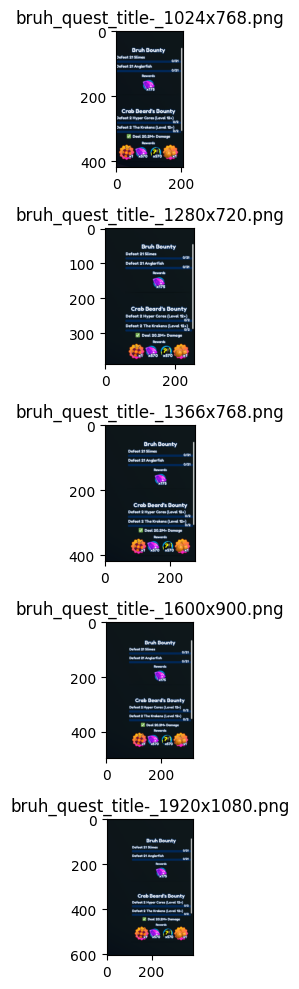

In [3]:
# vamos fazer um crop em todas as imagens do crab quest title para a regiao onde o texto esta
# e vamos salvar em uma pasta chamada crab_quest_title_text
import PIL
import matplotlib.pyplot as plt

folder_name = "bruh_quest_title"
needle_name = "bruh_quest_title.png"
save_folder = "bruh_quest_title"

files = [f for f in os.listdir(f"../tests/assets/{folder_name}") if f.endswith(".png")]

fig, ax = plt.subplots(len(files), 1, figsize=(10, 10))

for ax_index, file in enumerate(files):
    w, h = PIL.Image.open(f"../tests/assets/{folder_name}/{file}").size
    crop = (8*(w//10), h *0.2, w, h*0.8)

    img = PIL.Image.open(f"../tests/assets/{folder_name}/{file}")
    img = img.crop(crop)

    ax[ax_index].imshow(img)
    ax[ax_index].set_title(file)

    if not os.path.exists(f"../tests/assets/{save_folder}"):
        os.makedirs(f"../tests/assets/{save_folder}")
    # salva o crop
    img.save(f"../tests/assets/{save_folder}/{file}")
fig.tight_layout()
plt.show()


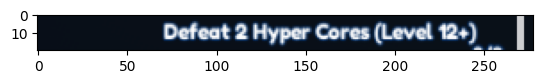

In [53]:
import matplotlib.pylab as plt
import cv2 as cv
import pytesseract


image = cv.imread("../tests/assets/crab_quest_title_text/crab_quest_title-_1366x768.png", cv.IMREAD_COLOR)

assert image is not None, "Image not found"
# para 1920x1080:
# 350: 600 e 1600:1900

# para 1024x768
# 200:400 e 800:1004


crop = image[220:240, 0:800]

# para 1024x768
# width: 200
# height: 20


plt.imshow(crop)

plt.show()



In [60]:
import pytesseract
t = pytesseract.image_to_string(crop)
print(t)

Defeat 2 Hveer Cores (Level 12+)



In [45]:
image

In [ ]:
image = cv.imread("./edmacro/teste.png", cv.IMREAD_UNCHANGED)
text = pytesseract.image_to_string(image)

print(text)

Crab Beard's Bounty
Defeat 2 Hyper Cores (Level 12+) |
Defeat 2 The Krakens (Level 12+)

@ Deal 20.2M+ Damage
norts  Clté‘é‘dz



IndentationError: expected an indented block after 'if' statement on line 68 (__init__.py, line 70)